In [1]:
import numpy as onp
import pandas as pd
import torch
import sklearn

# visualization
import seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner

%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.auto import tqdm
import itertools
import numpy.random as npr
import jax
import optax 


In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as np

import flows

from jax import grad, jit, random
from jax.experimental import stax, optimizers
import numpyro

In [4]:
rng, flow_rng = random.split(random.PRNGKey(0))



In [5]:

def hmc(flow_params, obs, init_theta,
        adapt_step_size=True,
        adapt_mass_matrix=True,
        dense_mass=True,
        step_size=1e0,
        max_tree_depth=12,
        num_warmup=100,
        num_samples=50,
        num_chains=1,
        seed=1234):
    
    def log_prior(theta):
        """unit gaussian about 0
        """
        dim = theta.shape[-1]
        return -0.5*(dim*np.log(2*np.pi) + np.log(1) + (theta)**2).sum()
    
    def posterior_wrapper(theta):
        if len(theta.shape) == 1:
            theta = theta[None, :]
        inputs = np.hstack([obs, theta])
        log_post = log_pdf(flow_params, inputs) # + log_prior(theta)
        return -log_post[0]

    hmc_key = random.PRNGKey(seed)
    nuts_kernel = numpyro.infer.NUTS(potential_fn=posterior_wrapper, 
                                     adapt_step_size=adapt_step_size, 
                                     adapt_mass_matrix=adapt_mass_matrix,
                                     dense_mass=dense_mass,
                                     step_size=step_size, 
                                     max_tree_depth=max_tree_depth)
    mcmc = numpyro.infer.MCMC(nuts_kernel, 
                              num_samples=num_samples, 
                              num_warmup=num_warmup, 
                              num_chains=num_chains)

    #TODO: make sure x0 is being used in posterior (because it's not being used in run)
    mcmc.run(hmc_key, init_params=init_theta)
    return mcmc

In [6]:
import dataset
import sklearn.preprocessing

In [7]:
# create observation
_observation = torch.tensor([[0.12, 120.]])
sigma_obs = np.array([0.01, 2.])

In [8]:
Dataset = dataset.get_dataset(N=150000, 
                              sigma_obs=sigma_obs,
                              rand_key=rng, 
                              use_logit=True)

/media/jt/data/Projects/MSSM/datasets/Hollingsworth/read_dataset.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['chg2'][np.where(np.isnan(f['chg2']))[0]]=-1


In [9]:
training_dataloader = torch.utils.data.DataLoader(Dataset, 
                                                  batch_size=128, 
                                                  shuffle=True, 
                                                 )

In [10]:
obs_dim = Dataset.obs.shape[-1]
theta_dim = Dataset.thetas.shape[-1]

In [11]:
init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5),
    flows.Normal(),
)


initial_params, log_pdf, sample = init_fun(flow_rng, obs_dim+theta_dim)


In [12]:
max_norm = 0.01
learning_rate = 1e-4
sync_period = 5
slow_step_size = 0.5

fast_optimizer = optax.chain(
    # Set the parameters of AdamW. 
    optax.adam(learning_rate=learning_rate, b1=0.9, b2=0.999, eps=1e-8),
    optax.adaptive_grad_clip(max_norm),
)
optimizer = optax.lookahead(fast_optimizer, sync_period=sync_period, slow_step_size=slow_step_size)

# The lookahead optimizer wrapper keeps a pair of slow and fast parameters. To
# initialize them, we create a pair of synchronized parameters from the
# initial model parameters. The first line below is only necessary for the
# lookahead wrapper; without it the initial parameters could be used in the
# initialization function of the optimizer directly.
params = optax.LookaheadParams.init_synced(initial_params)
opt_state = optimizer.init(params)
losses = []
results = []
best_results = np.inf


In [13]:
# find the most likely point in the training set to set initial params
data = np.hstack([Dataset.obs, Dataset.thetas])
temp = data.copy()
temp = np.hstack([np.repeat(_observation.numpy(), temp.shape[0], axis=0), temp[:, 2:]])
temp = np.hstack(Dataset.transform(torch.tensor(onp.array(temp[:, :2])), 
                                   torch.tensor(onp.array(temp[:, 2:]))))

observation, _ = Dataset.transform(_observation.clone(), torch.rand(1, 4))

In [14]:
num_steps = 100000
batch_size = 128
itercount = itertools.count()
try:
    iterator = tqdm(range(num_steps))
    for step_num in iterator:
        batch = np.hstack(next(iter(training_dataloader)))

        nll, params, opt_state = step(params, opt_state, batch)
        losses.append(nll)

        # see how well the observations are recovered
        if step_num % 500 == 0:
            likelihoods = log_pdf(params.slow, temp)
                
            res = data[np.argmax(likelihoods).item()][:obs_dim]
            print(res)
            res, _ = Dataset.transform(torch.tensor(onp.array(res)), torch.rand(1, 4))
            res = (observation - res)/(observation)
            res = np.abs(np.prod(res.numpy()))
            if res < best_results:
                best_results = res
                trained_params = params.slow.copy()
                iterator.set_description(f"Best likelihood product: {np.log(best_results)}")
            results.append(res)
except KeyboardInterrupt:
    pass

  0%|          | 0/100000 [00:00<?, ?it/s]

[ 93.5128 118.402 ]
[  5.53498 119.523  ]
[  0.448979 119.777   ]
[  0.373699 119.787   ]
[  0.224386 119.511   ]
[  0.166003 119.354   ]
[  0.143412 119.293   ]
[  0.143412 119.293   ]
[  0.125613 119.248   ]
[  0.125307 119.22    ]
[  0.125307 119.22    ]
[  0.125613 119.248   ]
[  0.12688 119.312  ]
[  0.12688 119.312  ]
[  0.12688 119.312  ]
[  0.121138 119.13    ]
[  0.12688 119.312  ]
[  0.121138 119.13    ]
[  0.121138 119.13    ]


In [15]:
likelihoods = log_pdf(trained_params, temp)

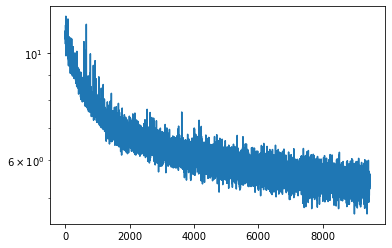

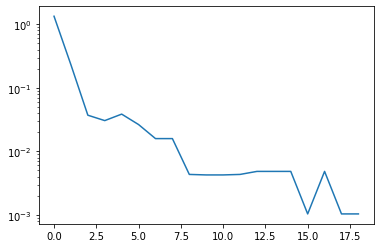

In [16]:
plt.plot(losses)
plt.yscale('log')
# plt.ylim(2.5, 10)

plt.show()
plt.plot(np.abs(np.vstack(results)))
plt.yscale('log')


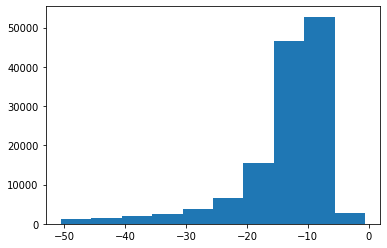

In [17]:
width = likelihoods.max() - likelihoods.min()
width = np.clip(width, 0, 100)
plt.hist(likelihoods, range=(likelihoods.max() - width/2, likelihoods.max()));

In [22]:
# put together init_params
num_chains = 1
init_theta = data[np.argmax(likelihoods).item()][obs_dim:]
_, init_theta = Dataset.transform(torch.rand(1, 2), torch.tensor(onp.array(init_theta)))
init_theta = np.array([init_theta.numpy() for _ in range(num_chains)])


mcmc = hmc(flow_params=params.slow, 
           obs=observation*1.0, 
           init_theta=init_theta,
           adapt_step_size=True,
           adapt_mass_matrix=True,
           dense_mass=True,
           step_size=4e-2,
           max_tree_depth=10,
           num_warmup=10000,
           num_samples=10000,
           num_chains=num_chains,
           seed=1234,
          )

sample: 100%|██████████| 20000/20000 [00:06<00:00, 2950.16it/s, 15 steps of size 6.43e-02. acc. prob=0.75]


In [23]:
mcmc.print_summary()
samples = mcmc.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]     -1.76      1.73     -2.32     -4.15      1.14    366.12      1.00
Param:0[0,1]     -0.52      0.89     -0.72     -1.79      1.06    641.94      1.00
Param:0[0,2]     -0.32      0.27     -0.42     -0.63      0.10    590.49      1.01
Param:0[0,3]      1.34      1.29      1.25     -0.68      3.46   1407.79      1.00

Number of divergences: 672


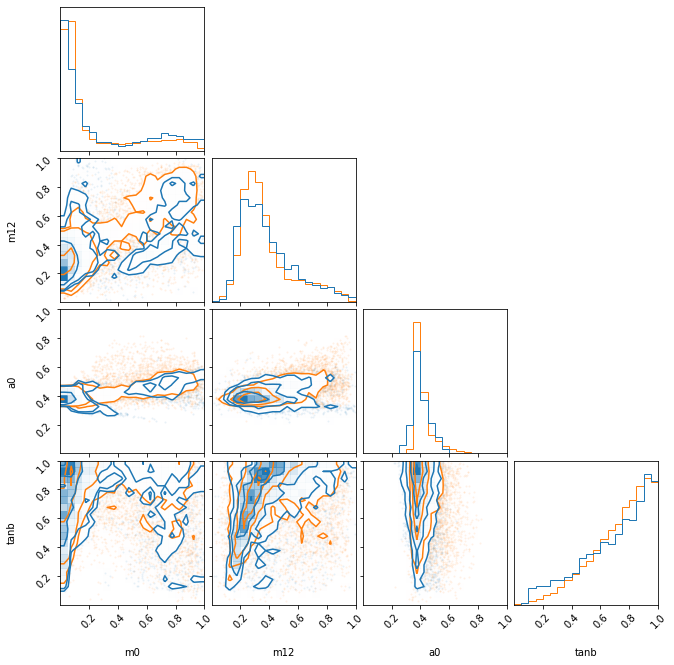

In [24]:
Omega, delta_Omega = _observation[0,0].item(), 0.02
mh, delta_mh = _observation[0, 1].item(), 2.

_temp = data.copy()

correct_Omega_idx = (_temp[:, 0] <= Omega + delta_Omega*2) & (_temp[:, 0]  >= Omega - delta_Omega*2)
correct_mh_idx = (_temp[:, 1] <= mh + delta_mh*2) & (_temp[:, 1] >= mh - delta_mh*2)

correct_omega_cMSSM = _temp[correct_Omega_idx]
correct_mh_cMSSM = _temp[correct_mh_idx]
correct_combo_cMSSM = _temp[correct_mh_idx & correct_Omega_idx]

# _, dset_samples = Dataset.transform(torch.rand(1, 2), 
#                                     torch.tensor(correct_combo_cMSSM[:, obs_dim:]))
dset_samples = correct_combo_cMSSM[:, obs_dim:]
dset_samples = (dset_samples - Dataset.thetas.min(axis=0).values.numpy())/(Dataset.thetas.max(axis=0).values.numpy() - Dataset.thetas.min(axis=0).values.numpy())


param_cols = ['m0', 'm12', 'a0', 'tanb']
fig = corner.corner(onp.array(dataset.sigmoid(samples[:, 0]) ), 
                     labels=param_cols, 
                     range=[(0, 1) for i in range(4)],
                     title='valid cMSSM', 
                     color='C1',
                     hist_kwargs={'color':'C1',"density":True});

fig = corner.corner(onp.array(dset_samples), 
             title='Correct Omega and mh', 
             range=[[0, 1] for i in param_cols], 
                     
             color='C0',
                    hist_kwargs={'color':'C0',"density":True}, 
                    fig=fig,
                   );


$$y = f(x)$$
$$p(y) = p(f^{-1}(y))\frac{df^{-1}}{dy}$$

so

$$p(x) = p(f(x))\frac{df}{dx}$$
if we logit
$$f(x) = \log\left(\epsilon + \frac{x}{1 - x + \epsilon}\right)$$

$$\frac{df}{dx} = \frac{\epsilon + 1}{(1 + \epsilon - x)(x + \epsilon(1 - x) + \epsilon^2)}$$

Thus, 

$$p(x) = p(f(x))\left(\frac{\epsilon + 1}{(1 + \epsilon - x)(x + \epsilon(1 - x) + \epsilon^2)}\right)$$

In [21]:
dset_samples.shape

(2937, 4)